In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
from collections import Counter, OrderedDict

In [2]:
pd.set_option('display.max_columns', 30)

In [3]:
sns.set_style('darkgrid')

In [4]:
plt.rcParams["figure.figsize"] = [10, 10]

In [5]:
age_df = pd.read_csv('../data/India/AgeGroupDetails.csv')

In [6]:
age_df.head(10)

,Sno,AgeGroup,TotalCases,Percentage
0,1,0-9,22,3.18%
1,2,10-19,27,3.90%
2,3,20-29,172,24.86%
3,4,30-39,146,21.10%
4,5,40-49,112,16.18%
5,6,50-59,77,11.13%
6,7,60-69,89,12.86%
7,8,70-79,28,4.05%
8,9,>=80,10,1.45%
9,10,Missing,9,1.30%


In [7]:
datetime_parser = lambda dt: datetime.strptime(x, '%Y-%m-%d %H:%M')

In [8]:
covid_df = pd.read_csv('../data/India/covid_19_india.csv', index_col='Sno')

In [9]:
hosp_df = pd.read_csv('../data/India/HospitalBedsIndia.csv')
hosp_df.head()

,Sno,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
0,1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
1,2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
2,3,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
3,4,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
4,5,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936


In [10]:
icmr_df = pd.read_csv('../data/India/ICMRTestingLabs.csv')
icmr_df.head()

,lab,address,pincode,city,state,type
0,"ICMR-Regional Medical Research Centre, Port Blair","ICMR-Regional Medical Research Centre, Post Ba...",744103,Port Blair,Andaman and Nicobar Islands,Government Laboratory
1,Tomo Riba Institute of Health & Medical Scienc...,"National Highway 52A, Old Assembly Complex, Na...",791110,Naharlagun,Arunachal Pradesh,Collection Site
2,Sri Venkateswara Institute of Medical Sciences...,Sri Venkateswara Institute of Medical Sciences...,517507,Tirupati,Andhra Pradesh,Government Laboratory
3,"Rangaraya Medical College, Kakinada","Rangaraya Medical College, Kakinada Pithampura...",533001,Kakinada,Andhra Pradesh,Government Laboratory
4,"Sidhartha Medical College, Vijaywada","Siddhartha Medical College, Vijayawada NH 16 S...",520008,Vijayawada,Andhra Pradesh,Government Laboratory


In [11]:
patients_df = pd.read_csv('../data/India/IndividualDetails.csv')
patients_df.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
2,2,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
3,3,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15/03/2020,"Travelled from Austria, Italy"
4,4,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02/03/2020,"Travelled from Dubai to Bangalore on 20th Feb,..."


In [12]:
patients_data = "https://api.covid19india.org/raw_data%d.json"
list_json_data = []

for i in range(1, 8):
    json_response = requests.get(patients_data % i).text
    list_of_patients = json.loads(json_response)['raw_data']
    list_json_data.extend(list_of_patients)

In [13]:
list_json_data[-1]

{'agebracket': '',
 'contractedfromwhichpatientsuspected': '',
 'currentstatus': '',
 'dateannounced': '',
 'detectedcity': '',
 'detecteddistrict': '',
 'detectedstate': '',
 'entryid': '92363',
 'gender': '',
 'nationality': '',
 'notes': '',
 'numcases': '',
 'patientnumber': '121728',
 'source1': '',
 'source2': '',
 'source3': '',
 'statecode': '',
 'statepatientnumber': '',
 'statuschangedate': '',
 'typeoftransmission': ''}

In [14]:
new_patients_df = pd.DataFrame(list_json_data)
new_patients_df.head(5)

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,gender,nationality,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,F,India,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,,India,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,,India,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,M,India,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,M,India,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [15]:
new_patients_df.to_csv('new_patients_data.csv')

In [16]:
state_testing_df = pd.read_csv('../data/India/StatewiseTestingDetails.csv')
state_testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [17]:
census_df = pd.read_csv('../data/India/population_india_census2011.csv')
census_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


### Data Cleaning

#### I. Covid 19 Data Frame

In [18]:
covid_df = pd.read_csv('../data/India/covid_19_india.csv', index_col='Sno')

In [19]:
covid_df.dtypes

Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [20]:
covid_df.Date = pd.to_datetime(covid_df.Date, format='%d/%m/%y')
covid_df = covid_df.rename(columns={"State/UnionTerritory": "State"})
covid_df.loc[:, 'Active'] = covid_df.loc[:, 'Confirmed'] - covid_df.loc[:, 'Deaths'] - covid_df.loc[:, 'Cured']
covid_df = covid_df[['Date', 'State', 'Cured', 'Deaths', 'Confirmed', 'Active']]
covid_df.loc[:, "Fatality Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100

In [21]:
covid_df = covid_df[~(covid_df.State == 'Cases being reassigned to states')]
yesterday = (datetime.datetime.now().date() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
latest_df = covid_df[covid_df.Date == yesterday]

#### Patients Df

In [22]:
new_patients_df = pd.DataFrame(list_json_data)

In [23]:
new_patients_df.head()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,gender,nationality,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,F,India,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,,India,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,,India,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,M,India,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,M,India,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [24]:
new_patients_df.dtypes

agebracket                             object
backupnotes                            object
contractedfromwhichpatientsuspected    object
currentstatus                          object
dateannounced                          object
detectedcity                           object
detecteddistrict                       object
detectedstate                          object
entryid                                object
estimatedonsetdate                     object
gender                                 object
nationality                            object
notes                                  object
numcases                               object
patientnumber                          object
source1                                object
source2                                object
source3                                object
statecode                              object
statepatientnumber                     object
statuschangedate                       object
typeoftransmission                

In [25]:
new_patients_df[new_patients_df['numcases'] == ''] = 0

In [26]:
new_patients_df[new_patients_df['patientnumber'] == ''] = 0

In [27]:
new_patients_df[['numcases', 'patientnumber']] = new_patients_df[['numcases', 'patientnumber']].astype(int)

In [28]:
new_patients_df.head()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,gender,nationality,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,F,India,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,,India,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,,India,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,M,India,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,M,India,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [29]:
new_patients_df_min = new_patients_df[['currentstatus', 'detectedcity', 
                                       'detecteddistrict', 'detectedstate',
                                      'gender', 'nationality', 'numcases', 'patientnumber', 'statepatientnumber'
                                       ,'typeoftransmission']]

In [30]:
new_patients_df_min.currentstatus.unique()

array(['Recovered', 'Hospitalized', 'Deceased', 'Migrated', 0,
       'Migrated_Other', ''], dtype=object)

In [31]:
new_patients_df_min.head()

,currentstatus,detectedcity,detecteddistrict,detectedstate,gender,nationality,numcases,patientnumber,statepatientnumber,typeoftransmission
0,Recovered,Thrissur,Thrissur,Kerala,F,India,1,1,KL-TS-P1,Imported
1,Recovered,Alappuzha,Alappuzha,Kerala,,India,1,2,KL-AL-P1,Imported
2,Recovered,Kasaragod,Kasaragod,Kerala,,India,1,3,KL-KS-P1,Imported
3,Recovered,East Delhi (Mayur Vihar),East Delhi,Delhi,M,India,1,4,DL-P1,Imported
4,Recovered,Hyderabad,Hyderabad,Telangana,M,India,1,5,TS-P1,Imported


In [32]:
new_patients_df_min[new_patients_df_min.currentstatus == 'Deceased'].head()

,currentstatus,detectedcity,detecteddistrict,detectedstate,gender,nationality,numcases,patientnumber,statepatientnumber,typeoftransmission
72,Deceased,Janakpuri,South West Delhi,Delhi,F,India,1,72,DL-P6,Local
76,Deceased,Mumbai,Mumbai,Maharashtra,M,India,1,77,,Imported
81,Deceased,Kalaburagi,Kalaburagi,Karnataka,M,India,1,74,KA-P6,Imported
181,Deceased,Banga,Shahid Bhagat Singh Nagar,Punjab,M,India,1,182,PJ-P2,Imported
269,Deceased,Mumbai,Mumbai,Maharashtra,M,India,1,270,,Imported


In [33]:
new_patients_df_min_deceased = new_patients_df_min[(new_patients_df_min.currentstatus == 'Deceased') & (new_patients_df_min.numcases > 0)]

In [34]:
new_patients_df_min_deceased = new_patients_df_min_deceased[~(new_patients_df_min_deceased.detecteddistrict == '')] 

### Statewise Testing

In [35]:
state_testing_df.dtypes

Date             object
State            object
TotalSamples    float64
Negative         object
Positive        float64
dtype: object

In [36]:
state_testing_df.Date = pd.to_datetime(state_testing_df.Date, format='%Y-%m-%d')

In [37]:
state_testing_df = state_testing_df.set_index('Date')

In [38]:
state_testing_df.describe()

,TotalSamples,Positive
count,2.508000e+03,2500.00000
mean,1.045378e+05,4916.88120
std,1.627766e+05,14396.57078
min,5.800000e+01,0.00000
25%,6.735500e+03,57.00000
50%,2.993250e+04,560.50000
75%,1.342415e+05,3314.75000
max,1.077454e+06,168388.00000


In [39]:
state_testing_df.isna().sum()

State             0
TotalSamples      0
Negative        692
Positive          8
dtype: int64

In [40]:
state_testing_df[state_testing_df['Positive'].isna()]

,State,TotalSamples,Negative,Positive
Date,,,,
2020-04-01,Delhi,2621.0,NaN,NaN
2020-04-05,Maharashtra,16008.0,14837,NaN
2020-04-04,West Bengal,1042.0,NaN,NaN
2020-04-06,West Bengal,1301.0,NaN,NaN
2020-04-07,West Bengal,1487.0,NaN,NaN
2020-04-09,West Bengal,1889.0,NaN,NaN
2020-04-10,West Bengal,2095.0,NaN,NaN
2020-05-01,West Bengal,18566.0,NaN,NaN


In [41]:
state_testing_df['Negative'] = state_testing_df['TotalSamples'] - state_testing_df['Positive']

In [42]:
state_testing_df.isna().sum()

State           0
TotalSamples    0
Negative        8
Positive        8
dtype: int64

In [43]:
state_testing_df = state_testing_df[~(state_testing_df.Positive.isna())]

In [44]:
covid_temp = covid_df

In [45]:
covid_temp = covid_temp.set_index('Date')

In [46]:
covid_temp.head()

,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Date,,,,,,
2020-01-30,Kerala,0,0,1,1,NaN
2020-01-31,Kerala,0,0,1,1,NaN
2020-02-01,Kerala,0,0,2,2,NaN
2020-02-02,Kerala,0,0,3,3,NaN
2020-02-03,Kerala,0,0,3,3,NaN


In [47]:
merged_df = pd.merge(covid_temp, state_testing_df, how='inner', left_index=True, right_index=True, on='State')

In [48]:
state_testing_temp = state_testing_df
state_testing_temp = state_testing_temp.set_index(['State'], append=True)
covid_temp = covid_temp.set_index(['State'], append=True)

In [49]:
merged_df = pd.merge(covid_temp, state_testing_temp, left_index=True, right_index=True, how='left').fillna(0)

In [50]:
merged_df = merged_df.sort_index(level=0, ascending=False)

## Data Analysis

### Top 10 States with Max Fatalities

In [51]:
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
3496,2020-06-28,Andaman and Nicobar Islands,43,0,72,29,0.000000
3497,2020-06-28,Andhra Pradesh,5480,157,12285,6648,2.864964
3498,2020-06-28,Arunachal Pradesh,54,1,177,122,1.851852
3499,2020-06-28,Assam,4500,9,6816,2307,0.200000
3500,2020-06-28,Bihar,6843,59,8931,2029,0.862195


In [52]:
latest_df = latest_df.sort_values(by='Deaths', ascending=False)
top_10_states_with_highest_fatalities = latest_df[:10]

In [53]:
top_10_states_with_highest_fatalities.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
3515,2020-06-28,Maharashtra,84245,7273,159133,67615,8.633153
3504,2020-06-28,Delhi,49301,2558,80188,28329,5.188536
3506,2020-06-28,Gujarat,22409,1789,30709,6511,7.983400
3525,2020-06-28,Tamil Nadu,44094,1025,78335,33216,2.324579
3529,2020-06-28,Uttar Pradesh,14215,649,21549,6685,4.565600


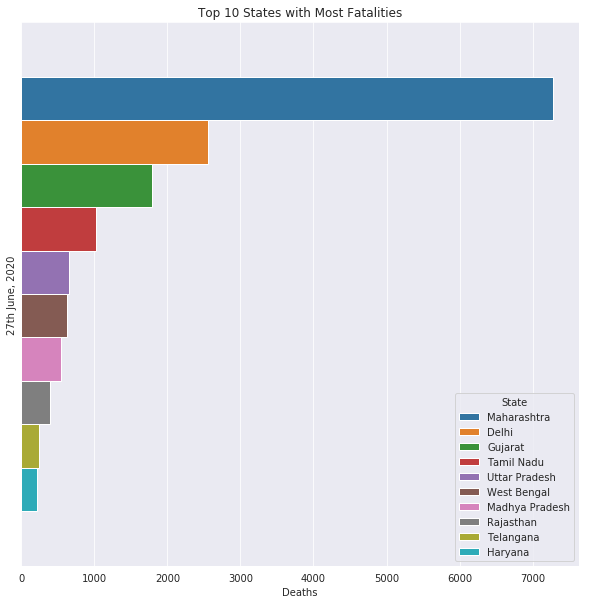

In [54]:
sns.barplot(y=top_10_states_with_highest_fatalities.Date, x=top_10_states_with_highest_fatalities.Deaths, hue=top_10_states_with_highest_fatalities.State, orient='h')
plt.title('Top 10 States with Most Fatalities')
plt.ylabel('27th June, 2020')
plt.yticks([])
plt.show()

### Top 10 States with Highest Fatality Rates

In [55]:
latest_df = latest_df.sort_values(by='Fatality Rate', ascending=False)

In [56]:
top_10_states_with_highest_fatality_rate = latest_df[:10]

In [57]:
top_10_states_with_highest_fatality_rate.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
3515,2020-06-28,Maharashtra,84245,7273,159133,67615,8.633153
3506,2020-06-28,Gujarat,22409,1789,30709,6511,7.983400
3530,2020-06-28,West Bengal,10789,629,16711,5293,5.830012
3514,2020-06-28,Madhya Pradesh,9971,550,12965,2444,5.515996
3504,2020-06-28,Delhi,49301,2558,80188,28329,5.188536


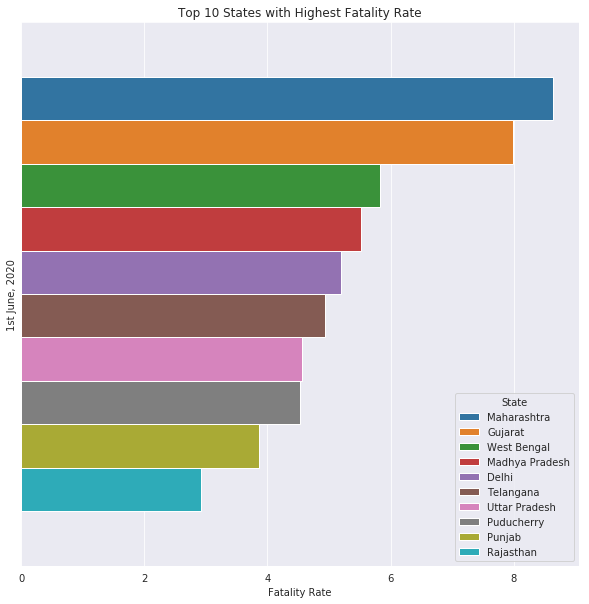

In [58]:
sns.barplot(y=top_10_states_with_highest_fatality_rate.Date, x=top_10_states_with_highest_fatality_rate['Fatality Rate'], hue=top_10_states_with_highest_fatality_rate.State, orient='h')
plt.title('Top 10 States with Highest Fatality Rate')
plt.ylabel('1st June, 2020')
plt.yticks([])
plt.show()

### Finding

- Maharashtra, having the highest number of fatalities due to Covid-19, has 4th highest mortality rate, since rate of recovery is high.
- West Bengal, having 5th highest number of fatalities, has highest mortality rate.

In [59]:
top_7_states = ["Maharashtra", 'Gujarat', 'Madhya Pradesh', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh']

In [60]:
top_7_states_df = covid_df[covid_df.State.isin(top_7_states)]
top_7_states_df = top_7_states_df.set_index('Date')

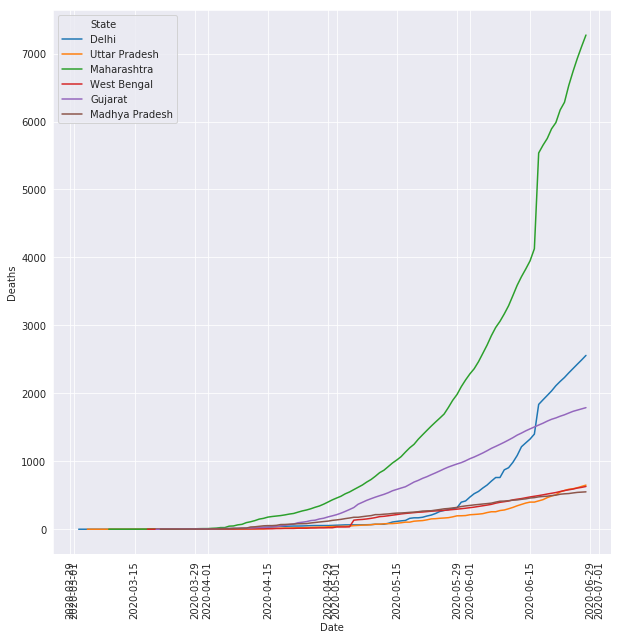

In [61]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Deaths, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

#### Finding:

- Uttar Pradesh, having highest population amongst Indian states has least number of fatalities.

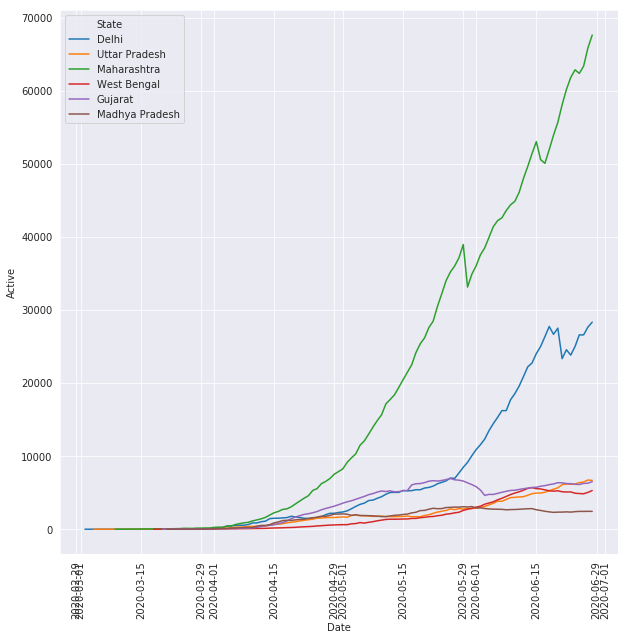

In [62]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Active, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

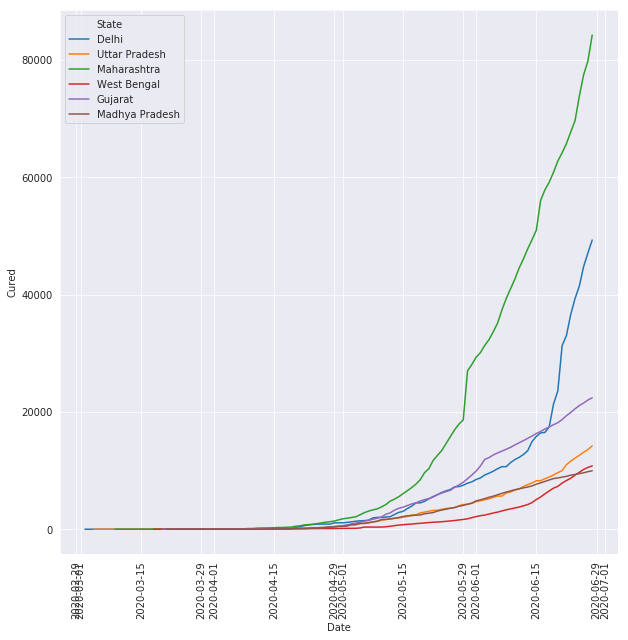

In [63]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Cured, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

#### Finding:
- West Bengal is one of the states with least recovery rate.

### Top 5 districts with maximum fatalities in India

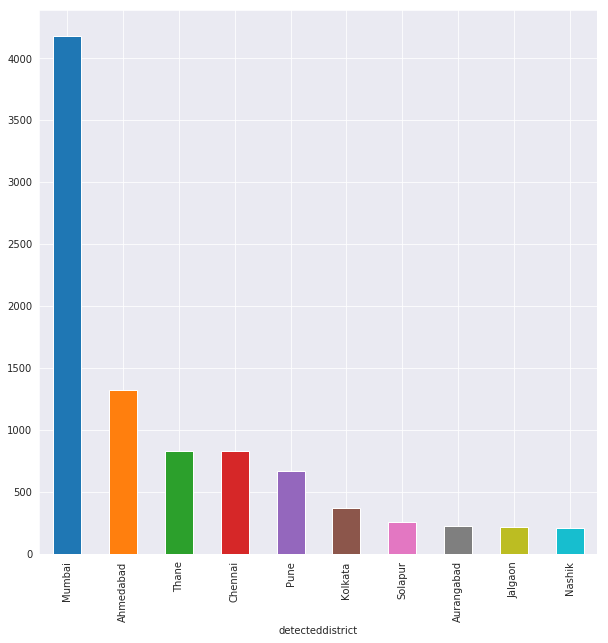

In [64]:
new_patients_df_min_deceased.groupby(['detecteddistrict'])['numcases'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

### Day wise Covid-19 statistics for each State

In [65]:
merged_df.head(20)

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-06-28 West Bengal     10789     629      16711    5293       5.830012   
           Uttarakhand      1912      37       2791     842       1.935146   
           Uttar Pradesh   14215     649      21549    6685       4.565600   
           Tripura          1071       1       1334     262       0.093371   
           Telangana        4928     243      13436    8265       4.931006   
           Tamil Nadu      44094    1025      78335   33216       2.324579   
           Sikkim             46       0         87      41       0.000000   
           Rajasthan       13367     391      16944    3186       2.925114   
           Punjab           3320     128       5056    1608       3.855422   
           Puducherry        221      10        619     388       4.524887   
           Odisha           4606      18       6350    1726       0.390795   
           Nagaland          164       0        387     223       0.000000   
           Mizoram            55       0        148      93       0.000000   
           Meghalaya          42       1         47       4       2.380952   
           Manipur           432       0       1092     660       0.000000   
           Maharashtra     84245    7273     159133   67615       8.633153   
           Madhya Pradesh   9971     550      12965    2444       5.515996   
           Ladakh            554       1        960     405       0.180505   
           Kerala           2110      22       4071    1939       1.042654   
           Karnataka        7287     191      11923    4445       2.621106   

                           TotalSamples  Negative  Positive  
Date       State                                             
2020-06-28 West Bengal              0.0       0.0       0.0  
           Uttarakhand              0.0       0.0       0.0  
           Uttar Pradesh            0.0       0.0       0.0  
           Tripura                  0.0       0.0       0.0  
           Telangana                0.0       0.0       0.0  
           Tamil Nadu               0.0       0.0       0.0  
           Sikkim                   0.0       0.0       0.0  
           Rajasthan                0.0       0.0       0.0  
           Punjab                   0.0       0.0       0.0  
           Puducherry               0.0       0.0       0.0  
           Odisha                   0.0       0.0       0.0  
           Nagaland                 0.0       0.0       0.0  
           Mizoram                  0.0       0.0       0.0  
           Meghalaya                0.0       0.0       0.0  
           Manipur                  0.0       0.0       0.0  
           Maharashtra         926934.0  758546.0  168388.0  
           Madhya Pradesh           0.0       0.0       0.0  
           Ladakh                   0.0       0.0       0.0  
           Kerala                   0.0       0.0       0.0  
           Karnataka                0.0       0.0       0.0

### State Level Aggregated DF with Census DF and Covid Counts

In [66]:
census_df = census_df.rename(columns={"State / Union Territory": "State"}).set_index('State').drop(columns='Sno')

In [67]:
aggregated_df = pd.merge(merged_df, census_df, left_index=True, right_index=True)

In [68]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-06-28 West Bengal    10789     629      16711    5293       5.830012   
           Uttarakhand     1912      37       2791     842       1.935146   
           Uttar Pradesh  14215     649      21549    6685       4.565600   
           Tripura         1071       1       1334     262       0.093371   
           Tamil Nadu     44094    1025      78335   33216       2.324579   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-06-28 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-06-28 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-06-28 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  
Date       State                        
2020-06-28 West Bengal             953  
           Uttarakhand             963  
           Uttar Pradesh           912  
           Tripura                 960  
           Tamil Nadu              996

In [69]:
hosp_df_min = hosp_df[['State/UT', 'NumPublicBeds_HMIS', 'NumRuralBeds_NHP18', 'NumUrbanBeds_NHP18']]

In [70]:
hosp_df_min = hosp_df_min.rename(columns={"State/UT":"State", "NumPublicBeds_HMIS": "Public Beds", 
                            "NumRuralBeds_NHP18": "Rural Beds", "NumUrbanBeds_NHP18": "Urban Beds"}).set_index('State')

In [71]:
aggregated_df = pd.merge(aggregated_df, hosp_df_min, left_index=True, right_index=True)

In [72]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-06-28 West Bengal    10789     629      16711    5293       5.830012   
           Uttarakhand     1912      37       2791     842       1.935146   
           Uttar Pradesh  14215     649      21549    6685       4.565600   
           Tripura         1071       1       1334     262       0.093371   
           Tamil Nadu     44094    1025      78335   33216       2.324579   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-06-28 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-06-28 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-06-28 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-06-28 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [73]:
fatality_df = covid_df[covid_df['Fatality Rate'].notna()]
fatality_df = fatality_df[~(fatality_df['Fatality Rate'] == np.inf)]
fatality_df.dtypes

Date             datetime64[ns]
State                    object
Cured                     int64
Deaths                    int64
Confirmed                 int64
Active                    int64
Fatality Rate           float64
dtype: object

In [74]:
fatality_df = fatality_df.set_index('Date')
fatality_rate_maha = fatality_df[fatality_df['State'] == 'Maharashtra']

In [75]:
states = ['Maharashtra', 'Delhi', 'Gujarat', 'Kerela', 'Madhya Pradesh', "Uttar Pradesh"]

In [76]:
df_temp = fatality_df[fatality_df.State.isin(states)]

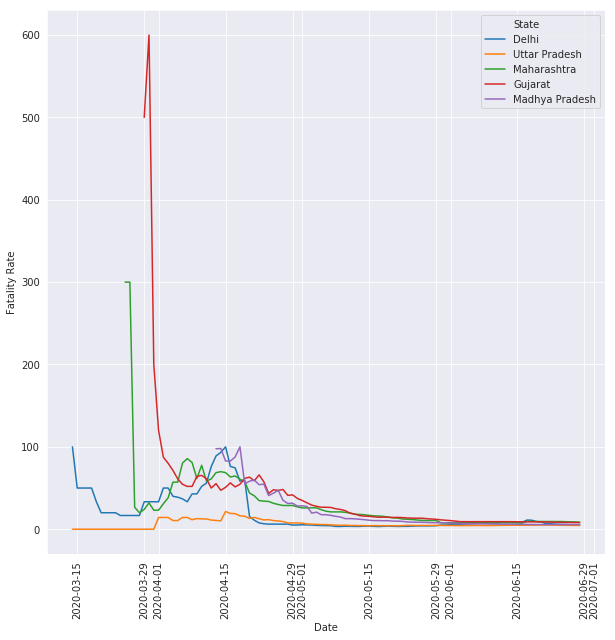

In [77]:
sns.lineplot(x=df_temp.index, y=df_temp['Fatality Rate'], hue=df_temp['State'])
plt.xticks(rotation=90)
plt.show()

In [78]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-06-28 West Bengal    10789     629      16711    5293       5.830012   
           Uttarakhand     1912      37       2791     842       1.935146   
           Uttar Pradesh  14215     649      21549    6685       4.565600   
           Tripura         1071       1       1334     262       0.093371   
           Tamil Nadu     44094    1025      78335   33216       2.324579   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-06-28 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-06-28 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-06-28 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-06-28 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [79]:
aggregated_df.loc[:, 'Total Beds'] = aggregated_df['Public Beds'] + aggregated_df['Rural Beds'] + aggregated_df['Urban Beds']

/home/akash/Dev/python/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [80]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == yesterday]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Confirmed > 1000]

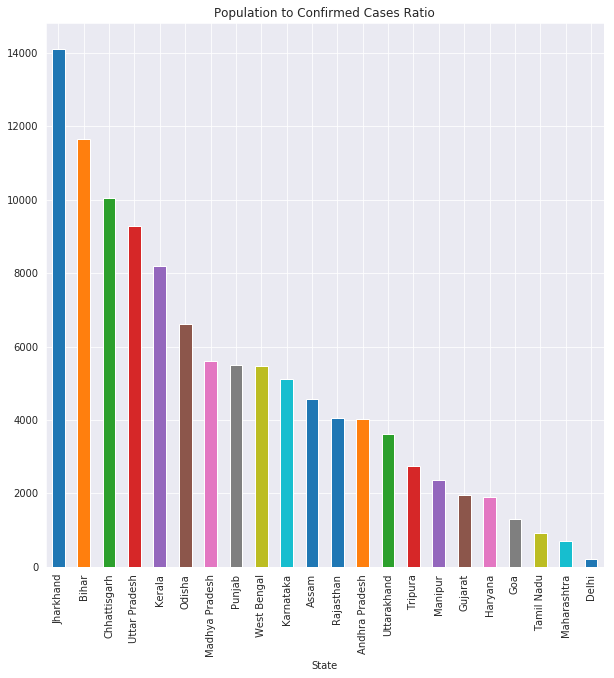

In [81]:
ser_pop_confirmed_ratio = (latest_df.Population / latest_df.Confirmed).sort_values(ascending=False)
ser_pop_confirmed_ratio.plot(kind='bar')
plt.title('Population to Confirmed Cases Ratio')
plt.show()

In [82]:
ser_pop_confirmed_ratio

State
Jharkhand         14103.520308
Bihar             11655.968201
Chhattisgarh      10037.405894
Uttar Pradesh      9272.464662
Kerala             8205.861213
Odisha             6610.113071
Madhya Pradesh     5601.759275
Punjab             5487.210839
West Bengal        5462.037879
Karnataka          5124.154743
Assam              4578.282864
Rajasthan          4045.587642
Andhra Pradesh     4035.580220
Uttarakhand        3613.863131
Tripura            2754.060720
Manipur            2353.836996
Gujarat            1968.142629
Haryana            1888.095777
Goa                1293.036348
Tamil Nadu          921.006319
Maharashtra         706.166119
Delhi               209.357273
dtype: float64

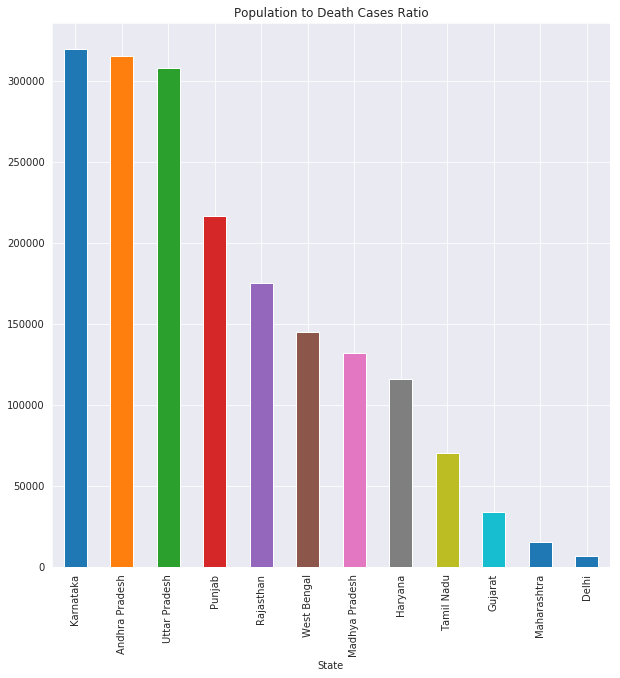

In [83]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == yesterday]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Deaths > 100]

ser_pop_deaths_ratio = (latest_df.Population / latest_df.Deaths).sort_values(ascending=False)
ser_pop_deaths_ratio.plot(kind='bar')
plt.title('Population to Death Cases Ratio')
plt.show()

In [84]:
ser_pop_deaths_ratio

State
Karnataka         319870.664921
Andhra Pradesh    315777.726115
Uttar Pradesh     307877.258860
Punjab            216744.828125
Rajasthan         175315.695652
West Bengal       145113.060413
Madhya Pradesh    132048.743636
Haryana           116291.110092
Tamil Nadu         70387.346341
Gujarat            33784.064841
Maharashtra        15450.891379
Delhi               6562.916732
dtype: float64

### Beds to Active Patients Ratio

In [85]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == yesterday, :].reset_index()
latest_df.loc[:, 'Beds/Active'] = latest_df['Total Beds'] / latest_df['Active']
df_least_beds_to_patients_ratio = latest_df.sort_values(by='Beds/Active', ascending=True).head(10)

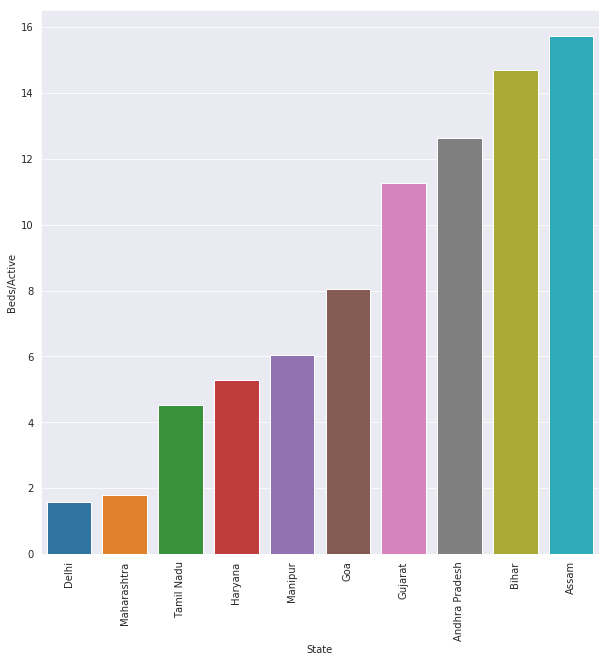

In [86]:
sns.barplot(x=df_least_beds_to_patients_ratio.State, y=df_least_beds_to_patients_ratio['Beds/Active'])
plt.xticks(rotation=90)
plt.show()

### Finding:

- As per above statistics, if we include only covid patients, there are only 2.5 beds available for 1 covid-19 patient in Maharashtra, which is alarming, given covid-19 is yet to peak.


- Also, there are only 2 beds available for each covid-19 patient in Delhi.

### Mortality rate per 1000000

In [87]:
latest_df.loc[:, 'Mortality/1000000'] = (latest_df['Deaths'] / latest_df['Population']) * 1000000
latest_df['Population_Density_square_km'] = latest_df['Density'].str.split('/').str[0]
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-06-28,West Bengal,10789,629,16711,5293,5.830012,0.0,0.0,0.0,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,24.509541,6.891178,"1,029"
1,2020-06-28,Uttarakhand,1912,37,2791,842,1.935146,0.0,0.0,0.0,10086292,7036954,3049338,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,18.019002,3.668345,189
2,2020-06-28,Uttar Pradesh,14215,649,21549,6685,4.565600,0.0,0.0,0.0,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,20.130142,3.248048,828
3,2020-06-28,Tripura,1071,1,1334,262,0.093371,0.0,0.0,0.0,3673917,2712464,961453,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,35.541985,0.272189,350
4,2020-06-28,Tamil Nadu,44094,1025,78335,33216,2.324579,0.0,0.0,0.0,72147030,37229590,34917440,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,4.520352,14.207099,555


In [88]:
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].str.replace(',', '')
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].astype(np.int)

In [89]:
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-06-28,West Bengal,10789,629,16711,5293,5.830012,0.0,0.0,0.0,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,24.509541,6.891178,1029
1,2020-06-28,Uttarakhand,1912,37,2791,842,1.935146,0.0,0.0,0.0,10086292,7036954,3049338,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,18.019002,3.668345,189
2,2020-06-28,Uttar Pradesh,14215,649,21549,6685,4.565600,0.0,0.0,0.0,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,20.130142,3.248048,828
3,2020-06-28,Tripura,1071,1,1334,262,0.093371,0.0,0.0,0.0,3673917,2712464,961453,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,35.541985,0.272189,350
4,2020-06-28,Tamil Nadu,44094,1025,78335,33216,2.324579,0.0,0.0,0.0,72147030,37229590,34917440,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,4.520352,14.207099,555


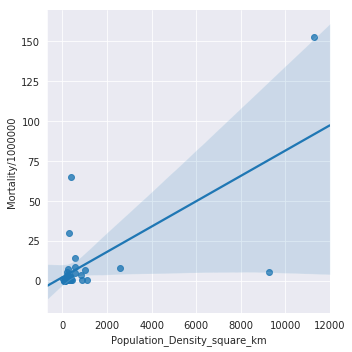

In [90]:
sns.lmplot(x='Population_Density_square_km', y='Mortality/1000000', data=latest_df)

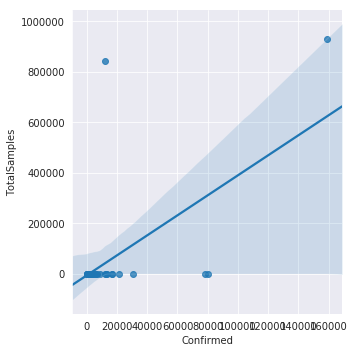

In [91]:
sns.lmplot(x='Confirmed', y='TotalSamples', data=latest_df)

In [92]:
covid_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
1,2020-01-30,Kerala,0,0,1,1,NaN
2,2020-01-31,Kerala,0,0,1,1,NaN
3,2020-02-01,Kerala,0,0,2,2,NaN
4,2020-02-02,Kerala,0,0,3,3,NaN
5,2020-02-03,Kerala,0,0,3,3,NaN


### Visual Analysis of most affected states

In [93]:
aggregated_df.index.get_level_values(1).unique()

Index(['West Bengal', 'Uttarakhand', 'Uttar Pradesh', 'Tripura', 'Tamil Nadu',
       'Sikkim', 'Rajasthan', 'Punjab', 'Puducherry', 'Odisha', 'Nagaland',
       'Mizoram', 'Meghalaya', 'Manipur', 'Maharashtra', 'Madhya Pradesh',
       'Kerala', 'Karnataka', 'Jharkhand', 'Himachal Pradesh', 'Haryana',
       'Gujarat', 'Goa', 'Delhi', 'Chhattisgarh', 'Chandigarh', 'Bihar',
       'Assam', 'Arunachal Pradesh', 'Andhra Pradesh'],
      dtype='object', name='State')

In [94]:
temp_df = aggregated_df.reset_index()
top_states_df = temp_df[temp_df['State'].isin(['Maharashtra', 'Gujarat', 'Tamil Nadu', 'Delhi', 'Madhya Pradesh'])].set_index(['Date', 'State']).sort_index(by='Date', ascending=True)[['Cured', 'Deaths', 'Confirmed', 'Active', 'Positive', 'TotalSamples', 'Negative']]

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [95]:
top_states_df_daily_counts = top_states_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff().fillna(top_states_df)
top_states_df_daily_counts = top_states_df_daily_counts.query('TotalSamples > 0')
top_states_df_daily_counts = top_states_df_daily_counts.query('Confirmed > 0')

In [96]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index('Date')

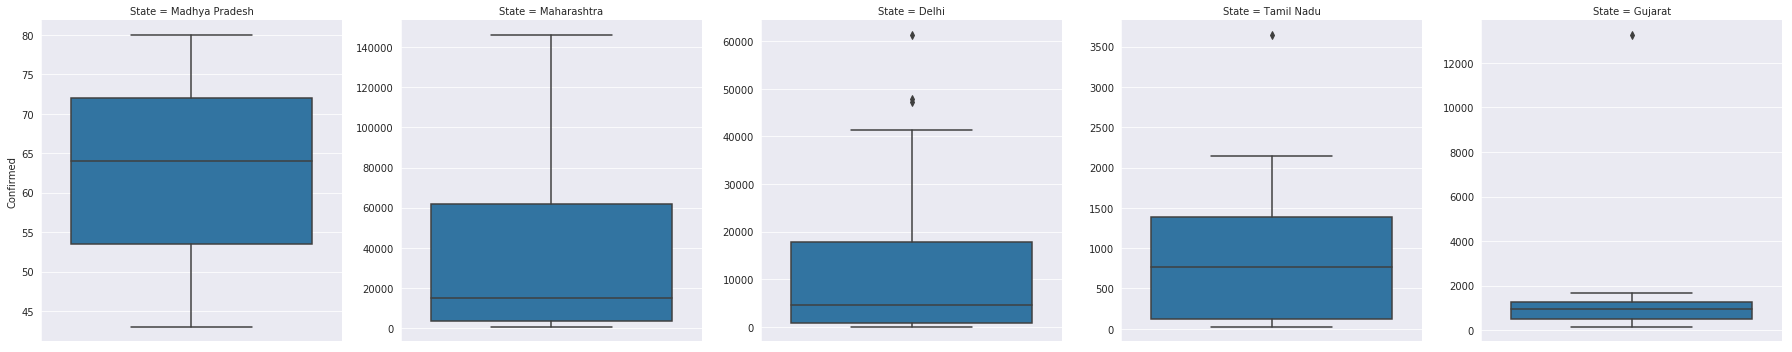

In [97]:
sns.catplot(y='Confirmed', kind='box' ,data=top_states_df_daily_counts, col='State', sharey=False)

In [98]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index(['Date', 'State'])

In [99]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Deaths > 0]
temp = temp.reset_index().set_index(['Date'])

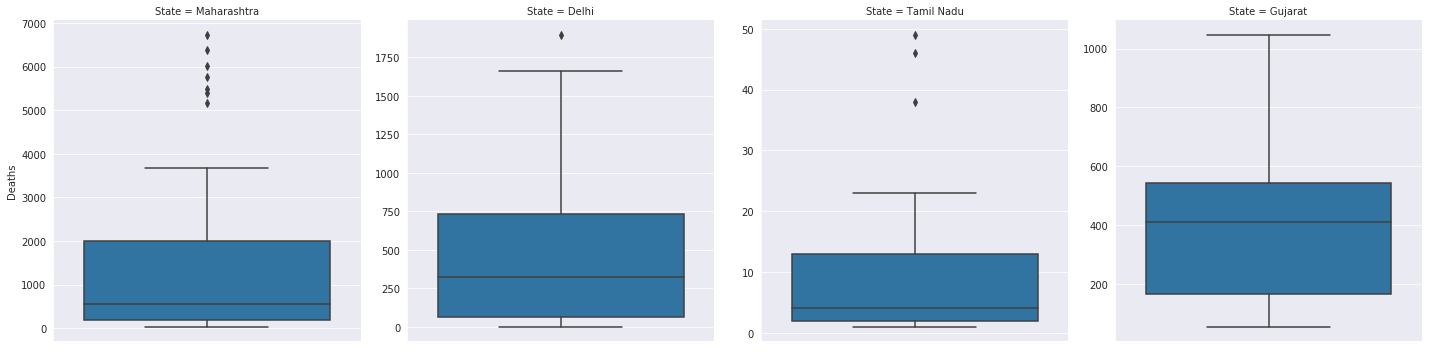

In [100]:
sns.catplot(y='Deaths', kind='box' ,data=temp, col='State', sharey=False)

In [101]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Confirmed > 0]
temp = temp.reset_index().set_index('Date')

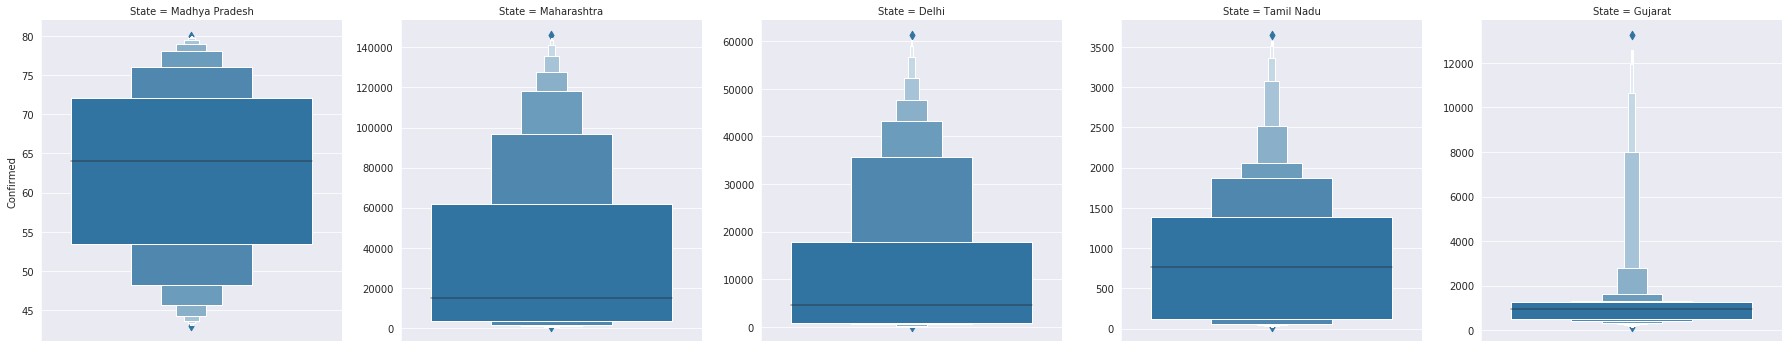

In [102]:
sns.catplot(y='Confirmed', data=temp, kind='boxen', sharey=False, col='State')

In [103]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Active > 0]
temp = temp.reset_index().set_index('Date')

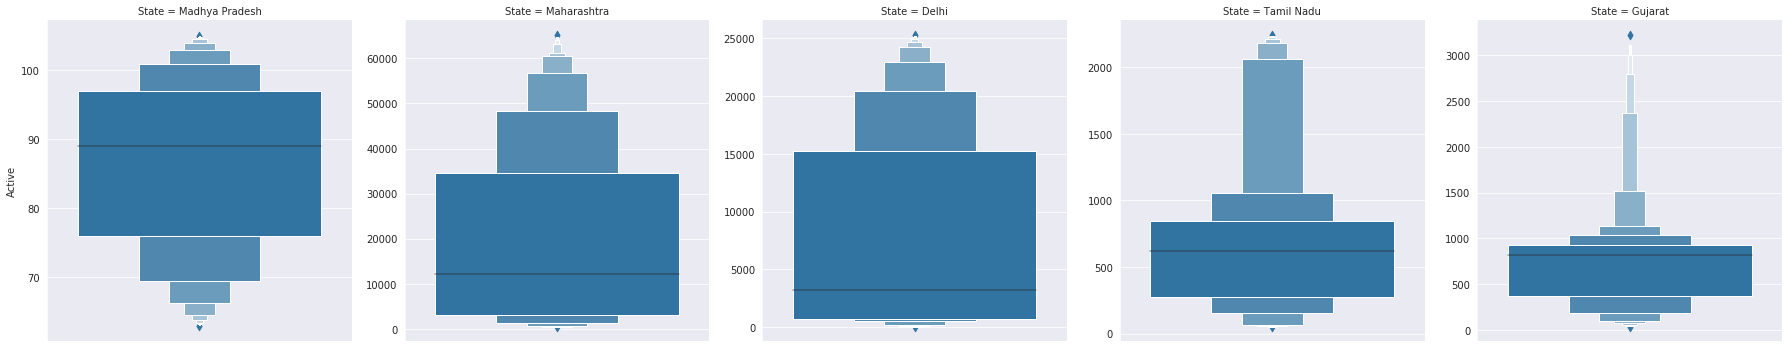

In [104]:
sns.catplot(y='Active', data=temp, kind='boxen', sharey=False, col='State')

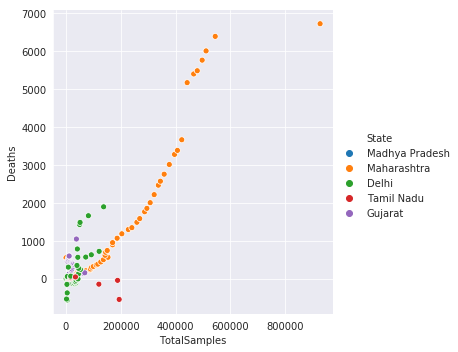

In [105]:
g = (sns.relplot(y='Deaths', x='TotalSamples', data=temp, kind='scatter', hue='State'))

#### Plot to show correlation between Confirmed Cases and Deaths

In [106]:
temp = temp.set_index('State', append=True)

In [107]:
temp = temp[(temp.values > 0).all(1)]
temp = temp.reset_index().set_index('Date')

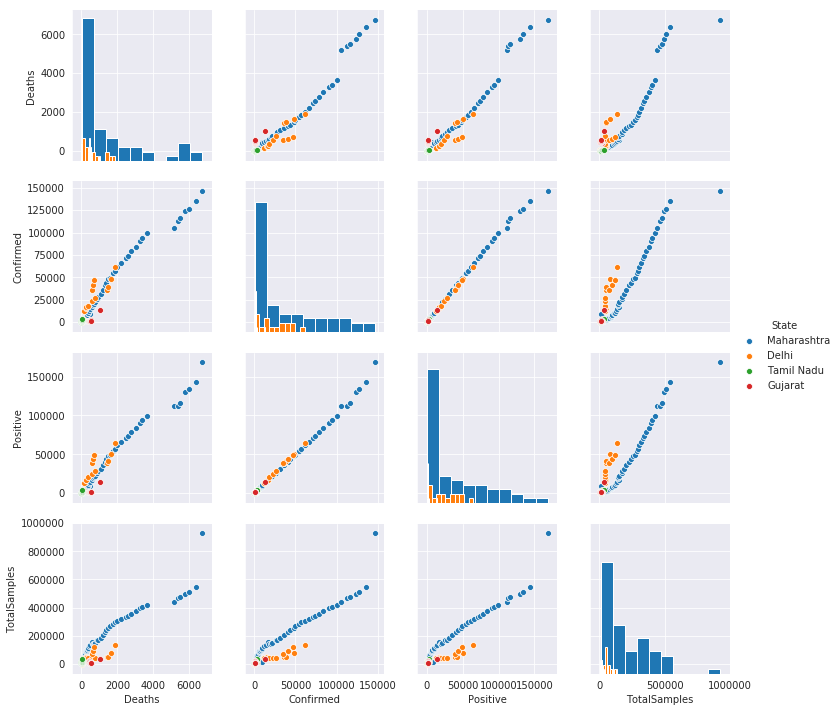

In [108]:
sns.pairplot(data=temp, vars=['Deaths', 'Confirmed', 'Positive', 'TotalSamples'], kind='scatter', diag_kind='hist', hue='State')

In [109]:
sorted_agg_df = aggregated_df.sort_index(level=0, ascending=True)

In [110]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-06-28 West Bengal    10789     629      16711    5293       5.830012   
           Uttarakhand     1912      37       2791     842       1.935146   
           Uttar Pradesh  14215     649      21549    6685       4.565600   
           Tripura         1071       1       1334     262       0.093371   
           Tamil Nadu     44094    1025      78335   33216       2.324579   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-06-28 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-06-28 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-06-28 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-06-28 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-06-28 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

### Maharashtra Covid Analysis 

In [111]:
maha_df = aggregated_df.query('State == "Maharashtra"').sort_index(by='Date', ascending=True).reset_index().set_index('Date')

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [112]:
maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].tail(10)

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-06-19,737597.0,60838,120504,5751,53915,617093.0,120504.0
2020-06-20,756809.0,62773,124331,5893,55665,632478.0,124331.0
2020-06-21,775958.0,64153,128205,5984,58068,647753.0,128205.0
2020-06-22,789016.0,65744,132075,6170,60161,656941.0,132075.0
2020-06-23,804726.0,67706,135796,6283,61807,662098.0,142628.0
2020-06-24,826139.0,69631,139010,6531,62848,679328.0,146811.0
2020-06-25,850410.0,73792,142900,6739,62369,698587.0,151823.0
2020-06-26,873570.0,77453,147741,6931,63357,717113.0,156457.0
2020-06-27,900423.0,79815,152765,7106,65844,738255.0,162168.0


In [113]:
maha_df_daily_counts = maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff()

In [114]:
df_t = maha_df_daily_counts.pct_change().dropna()

In [115]:
df_t = df_t[(df_t.values != np.inf).all(1)]

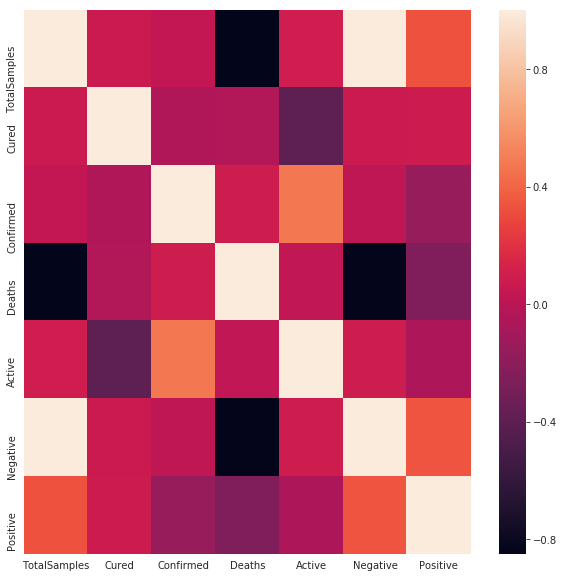

In [116]:
sns.heatmap(df_t.corr())

/home/akash/Dev/python/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


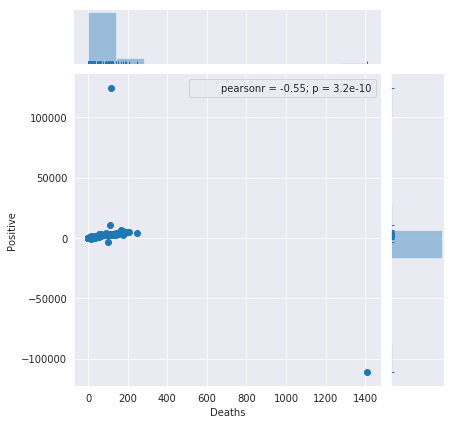

In [117]:
sns.jointplot(x='Deaths', y='Positive', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

In [118]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples > 0')

In [119]:
maha_df_daily_counts.head()

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-04-06,17563.0,14.0,258.0,21.0,223.0,16695.0,868.0
2020-04-07,3314.0,0.0,120.0,3.0,117.0,3164.0,150.0
2020-04-09,20877.0,38.0,117.0,8.0,71.0,20009.0,868.0
2020-04-10,9123.0,8.0,229.0,25.0,196.0,8856.0,267.0
2020-04-11,1841.0,63.0,210.0,13.0,134.0,1215.0,626.0


In [120]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples < 500000')

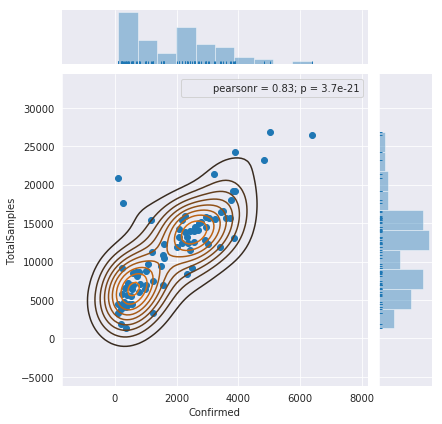

In [121]:
g = (sns.jointplot(x='Confirmed', y='TotalSamples', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)
    .plot_joint(sns.kdeplot))

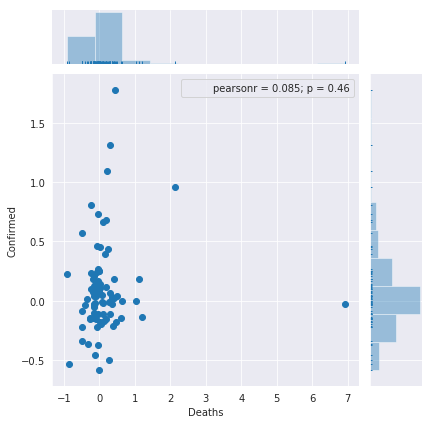

In [122]:
sns.jointplot(x='Deaths', y='Confirmed', data=df_t, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

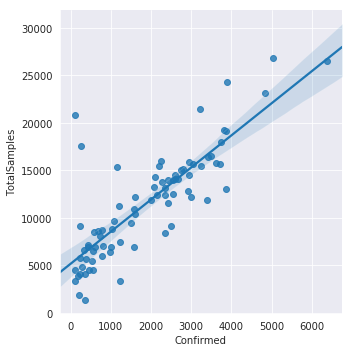

In [123]:
sns.lmplot(x='Confirmed', y='TotalSamples', data=maha_df_daily_counts)

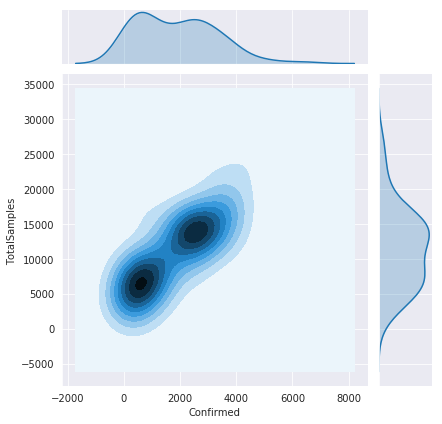

In [124]:
sns.jointplot(x='Confirmed', y='TotalSamples', data=maha_df_daily_counts, kind='kde')

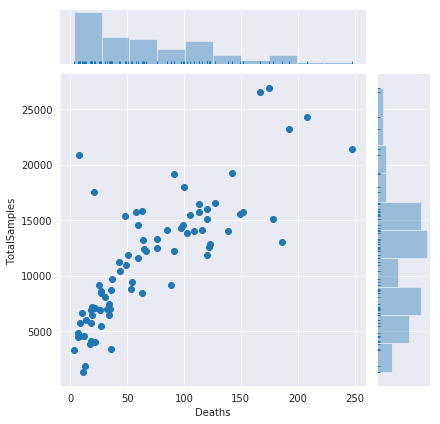

In [125]:
g = (sns.jointplot(x='Deaths', y='TotalSamples', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True))
    )

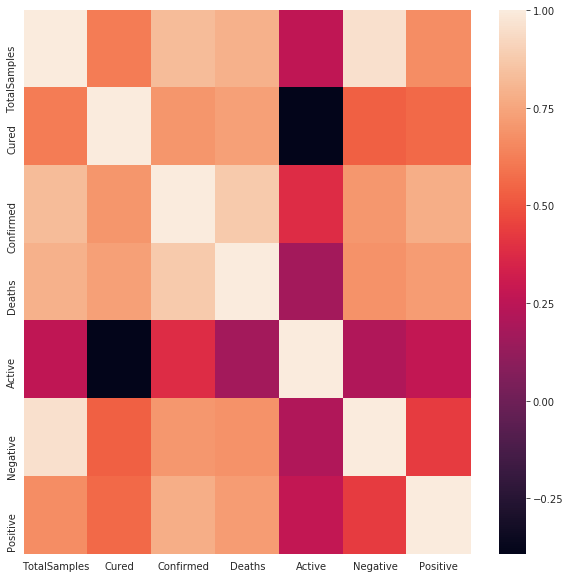

In [126]:
sns.heatmap(maha_df_daily_counts.corr())

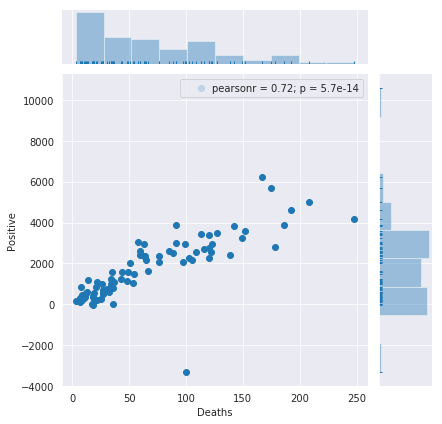

In [127]:
sns.jointplot(x='Deaths', y='Positive', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

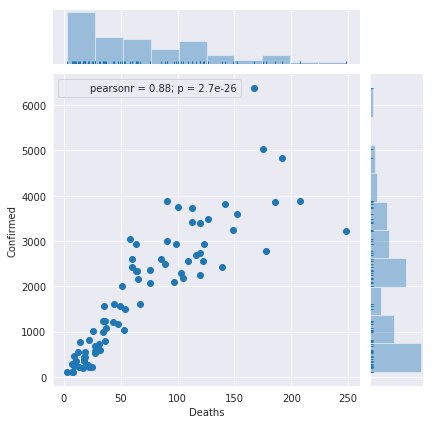

In [128]:
sns.jointplot(x='Deaths', y='Confirmed', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

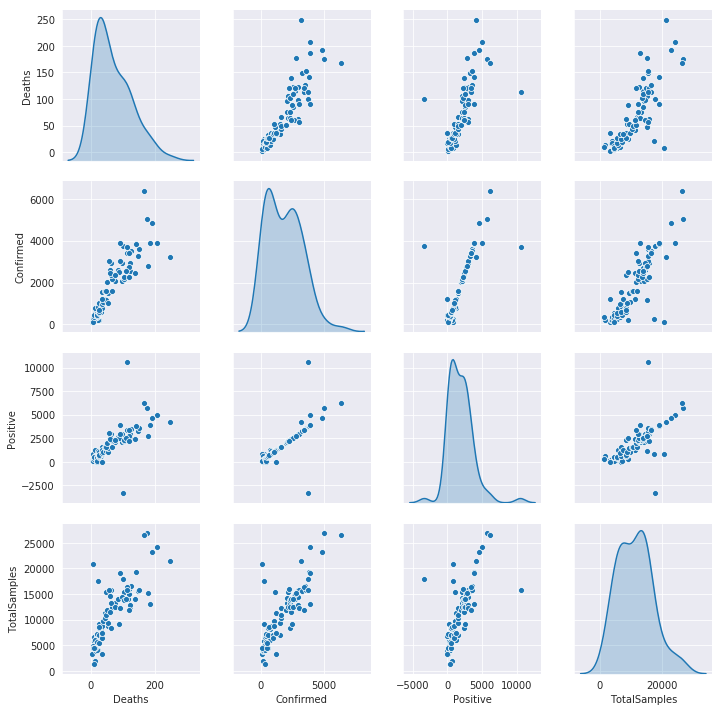

In [129]:
sns.pairplot(data=maha_df_daily_counts, vars=['Deaths', 'Confirmed', 'Positive', 'TotalSamples'], kind='scatter', diag_kind='kde')

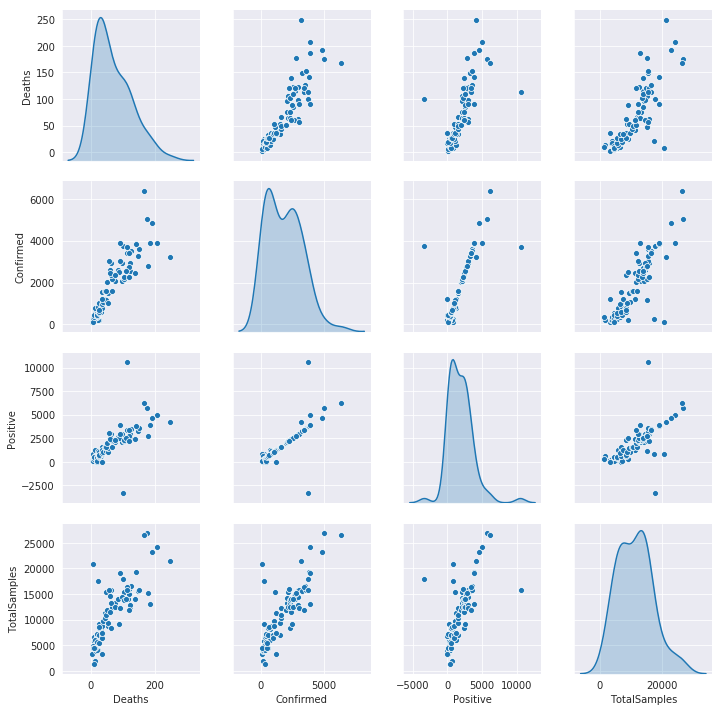

In [130]:
sns.pairplot(data=maha_df_daily_counts, vars=['Deaths', 'Confirmed', 'Positive', 'TotalSamples'], kind='scatter', diag_kind='kde', )

### Analyzing Each Lockdown 

In [131]:
start_lockdown1 = '2020-03-25'
end_lockdown1 = '2020-04-14'
start_lockdown2 = '2020-04-15'
end_lockdown2 = '2020-05-03'
start_lockdown3 = '2020-05-04'
end_lockdown3 = '2020-05-17'
start_lockdown4 = '2020-05-18'
end_lockdown4 = '2020-05-31'
start_lockdown5 = '2020-06-01'
end_lockdown5 = '2020-06-28'

In [132]:
lockdown1_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown1) & (aggregated_df.index.get_level_values(0) <= end_lockdown1)]
lockdown2_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown2) & (aggregated_df.index.get_level_values(0) <= end_lockdown2)]
lockdown3_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown3) & (aggregated_df.index.get_level_values(0) <= end_lockdown3)]
lockdown4_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown4) & (aggregated_df.index.get_level_values(0) <= end_lockdown4)]
lockdown5_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown5) & (aggregated_df.index.get_level_values(0) <= end_lockdown5)]

In [133]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Confirmed']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-04-14,2020-03-25,pct_increase1
2,Madhya Pradesh,730.0,14.0,5114.285714
3,Delhi,1510.0,31.0,4770.967742
7,West Bengal,190.0,9.0,2011.111111
8,Maharashtra,2337.0,128.0,1725.781250
11,Gujarat,617.0,38.0,1523.684211


In [134]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Confirmed']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-03,2020-04-15,pct_increase2
0,Gujarat,5055.0,695.0,627.338129
2,Maharashtra,12296.0,2687.0,357.610718
4,West Bengal,922.0,213.0,332.863850
9,Madhya Pradesh,2846.0,987.0,188.348531
12,Delhi,4122.0,1561.0,164.061499


In [135]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Confirmed']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,2576,963,167.497404
6,Maharashtra,30706,12974,136.673347
9,Delhi,9333,4549,105.165971
11,Gujarat,10988,5428,102.431835
18,Madhya Pradesh,4789,2942,62.780421


In [136]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Confirmed']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-31,2020-05-18,pct_increase4
15,Maharashtra,65168.0,33053.0,97.162134
16,West Bengal,5130.0,2677.0,91.632424
18,Delhi,18549.0,10054.0,84.493734
22,Madhya Pradesh,7891.0,4977.0,58.549327
25,Gujarat,16343.0,11379.0,43.624220


In [137]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [138]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Confirmed']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-06-28,2020-06-01,pct_increase5
11,Delhi,80188,19844,304.091917
19,West Bengal,16711,5501,203.781131
22,Maharashtra,159133,67655,135.212475
26,Gujarat,30709,16779,83.020442
28,Madhya Pradesh,12965,8089,60.279392


In [139]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5]

In [140]:
from functools import reduce

In [141]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [142]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat', 'Tamil Nadu'])][['State', 'pct_increase1', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5']]

In [143]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase1'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5']) / 5

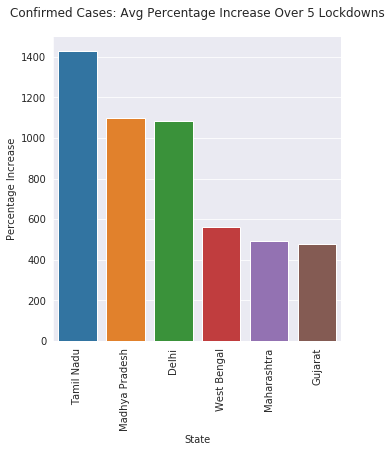

In [144]:
sns.catplot(x='State', y='avg_pct_inc', data=df_pct_inc, kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Percentage Increase')
plt.title('Confirmed Cases: Avg Percentage Increase Over 5 Lockdowns', pad=20)
plt.show()

### Computing Doubling Rate for each State

In [145]:
df10 = maha_df.drop_duplicates(subset='Confirmed')

In [146]:
def compute_doubling_rate(confirmed_series):
    return Counter(confirmed_series.apply(math.log2).apply(math.floor).values)

In [147]:
dict_doubling_rate = dict()
for state in aggregated_df.index.get_level_values(1).unique():
    state_df = aggregated_df.loc[aggregated_df.index.get_level_values(1) == state].reset_index().set_index('Date')
    state_df = state_df.drop_duplicates(subset='Confirmed')
    state_df = state_df[state_df.Confirmed > 0]
    counter = compute_doubling_rate(state_df.Confirmed)
    if len(counter) > 0:
        dict_doubling_rate[state] = OrderedDict(counter)

### Doubling Rate for Each State

In [148]:
doubling_rate_df = pd.DataFrame(dict_doubling_rate).fillna(0)
doubling_rate_df

,West Bengal,Uttarakhand,Uttar Pradesh,Tripura,Tamil Nadu,Sikkim,Rajasthan,Punjab,Puducherry,Odisha,Nagaland,Mizoram,Meghalaya,Manipur,Maharashtra,Madhya Pradesh,Kerala,Karnataka,Jharkhand,Himachal Pradesh,Haryana,Gujarat,Goa,Delhi,Chhattisgarh,Chandigarh,Bihar,Assam,Arunachal Pradesh,Andhra Pradesh
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
2,2.0,3.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,2.0,1.0,1.0,0.0,2.0,3.0,4.0,2.0,3.0,2.0,1.0,1.0,2.0
3,3.0,1.0,5.0,0.0,2.0,2.0,1.0,1.0,4.0,0.0,0.0,2.0,6.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,2.0,0.0,2.0,3.0,3.0,2.0,3.0,0.0,0.0,5.0
4,3.0,4.0,6.0,2.0,3.0,0.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,0.0,2.0,7.0,1.0,6.0,2.0,5.0,2.0,2.0,5.0,3.0,9.0,4.0,7.0,1.0,2.0
5,3.0,17.0,4.0,1.0,2.0,1.0,6.0,7.0,3.0,7.0,4.0,2.0,6.0,6.0,6.0,1.0,2.0,4.0,8.0,13.0,6.0,5.0,6.0,3.0,10.0,2.0,4.0,10.0,7.0,1.0
6,7.0,11.0,5.0,2.0,2.0,8.0,3.0,3.0,5.0,10.0,6.0,8.0,0.0,5.0,4.0,3.0,4.0,5.0,9.0,9.0,2.0,7.0,7.0,2.0,6.0,5.0,10.0,7.0,6.0,2.0
7,6.0,3.0,3.0,16.0,1.0,0.0,2.0,9.0,6.0,9.0,10.0,6.0,0.0,3.0,6.0,2.0,6.0,9.0,11.0,6.0,9.0,4.0,2.0,2.0,4.0,13.0,4.0,3.0,7.0,4.0
8,6.0,5.0,7.0,4.0,3.0,0.0,5.0,6.0,7.0,5.0,6.0,0.0,0.0,9.0,3.0,2.0,34.0,14.0,9.0,18.0,9.0,2.0,7.0,2.0,7.0,30.0,7.0,3.0,0.0,8.0
9,10.0,4.0,5.0,9.0,7.0,0.0,6.0,1.0,1.0,7.0,0.0,0.0,0.0,8.0,3.0,4.0,18.0,18.0,8.0,14.0,16.0,5.0,12.0,5.0,6.0,0.0,13.0,4.0,0.0,8.0


#### Inferences:

1. For confirmed cases, Maharashtra has a doubling rate of 21 days.
2. Delhi has a doubling rate of 13 days!


### India's doubling rate 

In [149]:
list_doubling_rate = []
for key, value in dict_doubling_rate.items():
    current_doubling_rate = value[list(value.keys())[0]]
    previous_doubling_rate = value[list(value.keys())[1]]
    doubling_rate =  current_doubling_rate if current_doubling_rate > previous_doubling_rate else previous_doubling_rate
    list_doubling_rate.append(doubling_rate)

In [150]:
sum(list_doubling_rate) / len(list_doubling_rate)

15.933333333333334

### Doubling Rate removing small states

In [151]:
list_doubling_rate = []
for key, value in dict_doubling_rate.items():
    current_doubling_rate = value[list(value.keys())[0]]
    previous_doubling_rate = value[list(value.keys())[1]]
    doubling_rate =  current_doubling_rate if current_doubling_rate > previous_doubling_rate else previous_doubling_rate
    if(doubling_rate > 11):
        list_doubling_rate.append(doubling_rate)

In [152]:
sum(list_doubling_rate) / len(list_doubling_rate)

18.434782608695652

### Forecasting Confirmed Cases in Maharashtra

In [153]:
def get_list_of_arma_model_parameters(df, no_of_lags):
    """ Helper Function to return list of tuple of ARMA params like (ar, ma, aic, bic)"""
    list_tup = []
    for i in range(10):
        for j in range(10):
            try:
                ARIMA_model = ARIMA(df, order=(i, no_of_lags, j)).fit(transparams=False)
                t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
                list_tup.append(t)
            except Exception as e:
                print(e)
    return list_tup

In [154]:
def get_best_ar_ma_value(list_of_tup):
    """ Helper Function to return best fit params from list of tuple of ARMA params like (ar, ma, aic, bic)"""
    least_bic = list_tup[0][3]
    best_params = list_tup[0]
    list_of_best_params = []
    for tup in list_of_tup:
        if tup[3] < least_bic:
            best_params = tup
            least_bic = tup[3]
    return best_params

In [155]:
d = df10[df10['Confirmed'].diff() > 0].fillna(df10)[['Confirmed']]
d = d.diff()
d = d.reset_index()

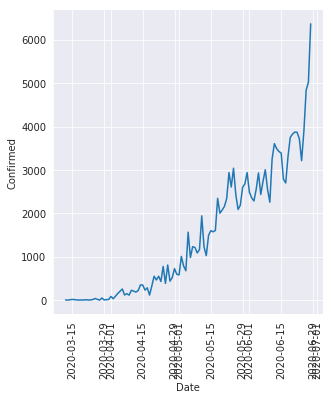

In [156]:
sns.relplot(y='Confirmed', x='Date', kind='line', data=d)
plt.xticks(rotation=90)
plt.show()

In [157]:
d = d.set_index('Date')

In [158]:
df_new = d[d['Confirmed'].diff() > 0].fillna(d)[['Confirmed']]
d2 = df_new.diff()
d2 = d2.diff()
d2 = d2.reset_index()
d2 = d2.dropna()

In [159]:
d = d.dropna()

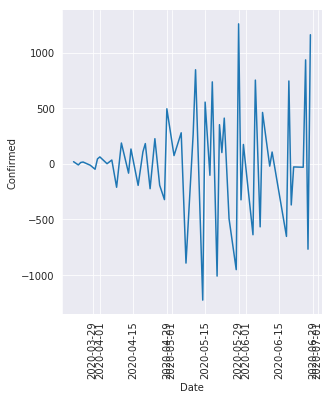

In [160]:
sns.relplot(y='Confirmed', x='Date', kind='line', data=d2)
plt.xticks(rotation=90)
plt.show()

In [161]:
d2 = d2.set_index('Date')

In [162]:
d2 = d2.dropna()

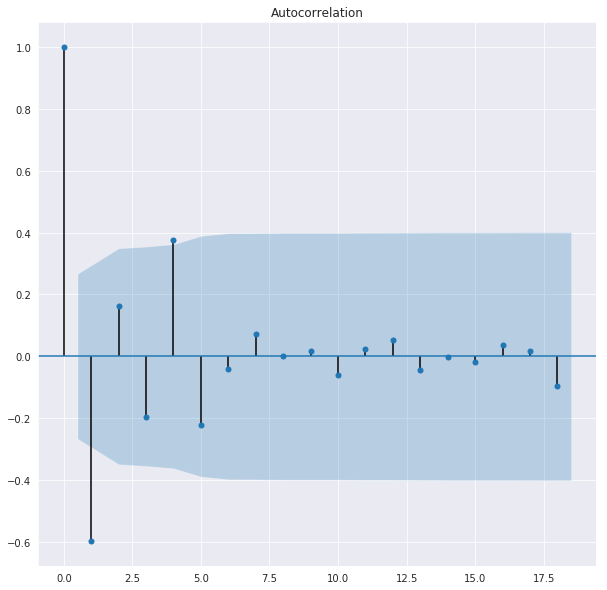

In [163]:
plot_acf(d2)
plt.show()

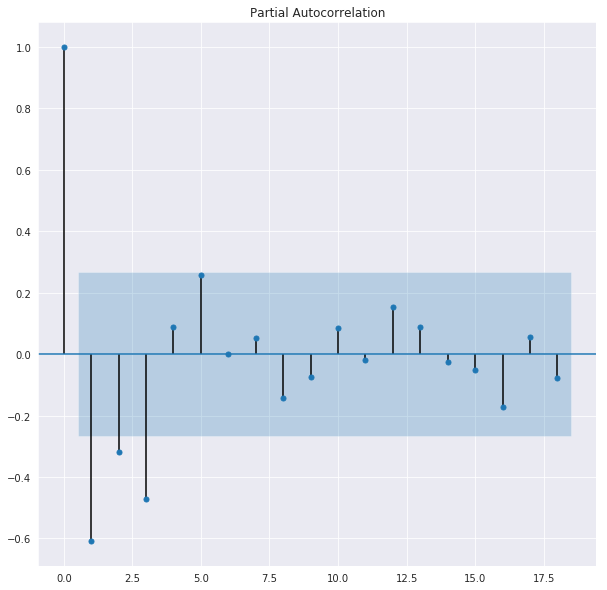

In [164]:
plot_pacf(d2)
plt.show()

In [165]:
list_tup = get_list_of_arma_model_parameters(d, 2)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not 

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergenc

SVD did not converge
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

On entry to DLASCL parameter number 4 had an illegal value
On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not s

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

On entry to DLASCL parameter number 4 had an illegal value
On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity,

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

In [166]:
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

In [167]:
ARMA_model = ARIMA(d, order=(ar, 2, ma)).fit()

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [168]:
ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.Confirmed   No. Observations:                  102
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -741.828
Method:                       css-mle   S.D. of innovations            340.756
Date:                Mon, 29 Jun 2020   AIC                           1489.656
Time:                        19:12:58   BIC                           1497.531
Sample:                             2   HQIC                          1492.845
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8925      1.129      1.676      0.094      -0.321       4.106
ma.L1.D2.Confirmed    -1.0000      0.028    -35.242      0.000      -1.056      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""